# Packages

In [1]:
from sympy.logic.boolalg import to_cnf
from sympy.abc import A, B, C, D, E, F, G, H, J
import itertools
import numpy as np
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
from timeit import default_timer
from sklearn.model_selection import train_test_split

In [2]:
%%capture
!pip install python-sat

In [3]:
from pysat.examples.fm import FM
from pysat.formula import WCNF
from itertools import combinations
import math

In [4]:
class Model:
    def __init__(self, n_neurons):
        self.n_neurons = n_neurons
        self.wcnf_form = WCNF()
        self.FuMalik = None

        self.weights_solution = None

    def compute_solution(self):
        self.FuMalik = FM(self.wcnf_form, verbose = 1)
        self.FuMalik.compute()

        self.weights_solution = self.FuMalik.model[:self.n_neurons]
        self.weights_solution = [val > 0 for val in self.weights_solution]  # Bool vector

    def append_positive_clause(self, data, target_index):
        # print(f'Encoding for y True')
        for positive_clause in data.positive_clauses:
            # if (1, -2) clause --> [(w[0] V ~x[i][0]) V (~w[1] V x[i][1])] clause
            clause_to_add = []
            for index in positive_clause:
                abs_index = abs(index)
                prop_weight = data.prop_weights[abs_index - 1]  # variable, where weight is encoded
                if target_index < len(data.prop_features):
                    if abs_index - 1 < len(data.prop_features[target_index]):
                        prop_feature = data.prop_features[target_index][abs_index - 1]  # feature, that is encoded

                        if index < 0:
                            clause_to_add.extend([int(-prop_weight), int(prop_feature)])
                        else:
                            clause_to_add.extend([int(prop_weight), int(-prop_feature)])
                    else:
                        print(f'Abs index: {abs_index}')
                else:
                    print(f'Target index {target_index}')
            # print(f'Clause: {clause_to_add}')
            self.wcnf_form.append(clause_to_add, weight = 1)

    def calc_update(self, letters, x, w):
        # ['~', 'x', '2']
        x_or_w = ''
        to_put_minus = 1

        if letters[0] == '~':
            x_or_w = letters[1]
            to_put_minus = -1
        else:
            x_or_w = letters[0]
            to_put_minus = 1
        
        index = int(letters[-1])
        if x_or_w == 'x':
            return int(to_put_minus * x[index - 1])
            
        if x_or_w == 'w':
            return int(to_put_minus * w[index - 1])

    def append_negative_clause(self, data, target_index):
        # print(f'Encoding for negative y')
        for negative_clause in data.negative_clauses:
            # ('w 1', 'x 1', '~ w 2', '~ x 2')

            clause_to_add = []
            for symbol in negative_clause:
                # symbol is a string, like "w 1" or "~ x 2"
                letters = symbol.split(' ')
                clause_to_add.append(int(self.calc_update(letters, data.prop_features[target_index], data.prop_weights)))
            
            # print(f'Clause: {clause_to_add}')
            self.wcnf_form.append(clause_to_add, weight = 1)


    def encode_soft_clauses(self, data):
        Y_train = data.Y_train

        for i in range(len(Y_train)):
    
            y_i = Y_train[i]

            if y_i == True:
                self.append_positive_clause(data, target_index = i)

            if y_i == False:
                self.append_negative_clause(data, target_index = i)
            
    def encode_hard_clauses(self, data):
        for i in range(len(data.X_train)):
            for j in range(len(data.X_train[0])):
                
                if data.X_train[i][j] == True:
                    self.wcnf_form.append([int(data.prop_features[i][j])])
                else:
                    self.wcnf_form.append([int(-data.prop_features[i][j])])

    def calc_accuracy(self, X, Y):
        int_weights = np.array(self.weights_solution, dtype = 'int')

        pred = np.sign(np.dot(X, int_weights))
        return accuracy_score(Y, pred)

    def calc_metrics(self, X, Y):

        acc = self.calc_accuracy(
            np.array(X, dtype = 'int'),
            np.array(Y, dtype = 'int')
        )
        # print(f'Accuracy: {acc}')
        return acc
        
class DataProperties:
    def __init__(self, n_features, n_samples, train_percentage):
        self.n_features = n_features
        self.n_samples = n_samples
        self.train_percentage = train_percentage
        self.test_percentage = 1 - train_percentage
        
        self.n_train = int(self.train_percentage * self.n_samples)
        self.n_test = self.n_samples - self.n_train

        self.X_train = None
        self.Y_train = None
        self.X_test = None
        self.Y_test = None
        
        self.prop_features = None
        self.prop_weights = np.array([i + 1 for i in range(n_features)])

        self.features_combinations = None
        self.cartesian_products = None

        self.positive_clauses = []
        self.negative_clauses = []
    
    def encode_propositional_features(self):
        self.prop_features = np.array(
            [[i*self.n_features + j + max(self.prop_weights) + 1 for j in range(self.n_features)] for i in range(self.n_train)]
        )

    def prepare_dataset(self, func):
        np.random.seed(123)

        sample_arr = [True, False]
        
        
        self.X_train = np.random.choice(sample_arr, size = (self.n_train, self.n_features))
        self.X_test = np.random.choice(sample_arr, size = (self.n_test, self.n_features))

        self.Y_train = [func(x) for x in self.X_train]
        self.Y_test = [func(x) for x in self.X_test]

    def prepare_balanced_dataset(self, func):
        # np.random.seed(123) 
        # print(f'Preparing balanced: n_train = {self.n_train}, n_test = {self.n_test}, n_features = {self.n_features}')
        
        X = list(itertools.product([False, True], repeat=self.n_features))
        Y = np.array([func(x) for x in X])
        # print(f'Len X, Y: {len(X), len(Y)}')

        idx_true = np.where(Y == True)[0]
        idx_false = np.where(Y == False)[0]
        assert(len(idx_true) + len(idx_false) == len(Y))

        # We need to balance dataset --> we will use the subsets
        # of True and False of equal cardinality (minimal of the
        # True or False subsets)
        min_length = min(len(idx_true), len(idx_false))

        y_balanced = []
        x_balanced = []

        # print(f'Min length: {min_length}')
        for i in range(min_length):
            true_idx = idx_true[i]
            false_idx = idx_false[i]
            
            y_balanced.append(Y[true_idx])
            x_balanced.append(X[true_idx])
            
            y_balanced.append(Y[false_idx])
            x_balanced.append(X[false_idx])

        # print(f'Len of balanced: {len(x_balanced), len(y_balanced)}')
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(
            x_balanced, 
            y_balanced, 
            stratify = y_balanced,
            test_size = self.n_test / self.n_train,
            random_state = 42
        )

        common_data = set(self.X_train).intersection(set(self.X_test))
        assert(len(common_data) == 0)  # No common data

    def encode_features_combinations(self):

        majority_size = int(np.ceil(self.n_features / 2))
        # assert(majority_size == np.floor(self.n_features / 2) + 1)
        self.features_combinations = list(combinations(self.prop_weights, majority_size))

    def remove_redundant(self, elements):
        res = []
        for e in elements:
            if not (e in res):
                res.append(e)
        return res

    def encode_cartesian_products(self):
        prods = list(itertools.product(*self.features_combinations))
        prods = [np.unique(combo).tolist() for combo in prods]
        self.cartesian_products = self.remove_redundant(prods)

    def prepare_predfinal_clauses(self):
        predfinal_clauses = []
        for product in self.cartesian_products:
            bracket = []
            for val in product:
                bracket.append([val, -val])
            predfinal_clauses.append(bracket)
        return predfinal_clauses


    def encode_positive_clauses(self):
        # Each element of optimized_products represents:
        # [1, 2] --> (w1 == x_i1) V (w2 == x_i2). But we have not transfered to CNF yet
        # To do that: [(~w1 V x_i1) & (w1 V ~x_i1)] V [(~w2 V x_i2) & (w2 V ~x_i2)]
        # which is 'encoded' as [[1, -1], [2, -2]]

        predfinal_clauses = self.prepare_predfinal_clauses()

        # And now we are creating final clauses
        for predfinal_clause in predfinal_clauses:
            clauses = list(itertools.product(*predfinal_clause))
            
            for clause in clauses:
                self.positive_clauses.append(clause)

    def encode_negative_clauses(self):

        ws_xs_list = []
        for combo in self.features_combinations:
            # print(combo)
            symbols = []
            for i in combo:
                symbols.extend([[f'w {i}', f'~ w {i}']])
                symbols.extend([[f'x {i}', f'~ x {i}']])
            ws_xs_list.append(symbols)
        
        for combination in ws_xs_list:
            for clause in itertools.product(*combination):
                # print(clause)
                self.negative_clauses.append(clause)


# Basic pipeline

## Prepare data, encode propositional features, compute solution

Distribution of Negative and positive classes in data:
Train acc: 0.782608695652174, Test acc: 0.6666666666666666


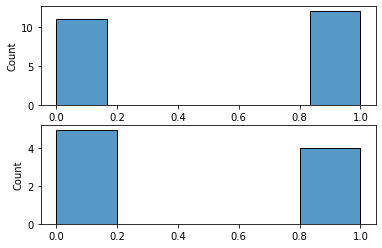

In [5]:
model = Model(n_neurons = 5)

data = DataProperties(
    n_features = model.n_neurons,
    n_samples = 2 ** model.n_neurons,
    train_percentage = 0.8  # test % = 100 - train %
)


# define propositional variables for X
# propositional features cannot have same indices as w --> + 1 + max(w)
data.encode_propositional_features()

# Now prepare all cartesian products (for the case whey y == 1)
data.encode_features_combinations()
data.encode_cartesian_products()

data.encode_positive_clauses()
data.encode_negative_clauses()

# Prepare data
def check_2nd_feature(x):
    return x[1] == True # and x[0] == False

data.prepare_balanced_dataset(func = check_2nd_feature)

# Distribution of dataset:
print(f'Distribution of Negative and positive classes in data:')
fig, ax = plt.subplots(2, 1)
sns.histplot(np.array(data.Y_train, dtype = 'int'), ax = ax[0])
sns.histplot(np.array(data.Y_test, dtype = 'int'), ax = ax[1])


model.encode_soft_clauses(data)
model.encode_hard_clauses(data)
model.compute_solution()

train_acc = model.calc_metrics(data.X_train, data.Y_train)
test_acc = model.calc_metrics(data.X_test, data.Y_test)

print(f'Train acc: {train_acc}, Test acc: {test_acc}')

# Numerical experiments

## Accuracy versus number of neurons

In [6]:
def run_experiment(
    target_func,
    data_size,
    train_percentage,
    n_neurons,
    do_computations,
    prepare_balanced
):
    model = Model(n_neurons = n_neurons)

    data = DataProperties(
        n_features = model.n_neurons,
        n_samples = data_size,
        train_percentage = train_percentage
    )

    data.encode_propositional_features()
    data.encode_features_combinations()
    data.encode_cartesian_products()
    data.encode_positive_clauses()
    data.encode_negative_clauses()
    # print(f'A')
    if prepare_balanced:
        data.prepare_balanced_dataset(func = target_func)
    else:
        data.prepare_dataset(func = target_func)
    # print(f'A')
    

    # Distribution of dataset:
    train_arr = np.array(data.Y_train, dtype = 'int')
    test_arr = np.array(data.Y_test, dtype = 'int')
    # print(f'{len(train_arr[train_arr == 1])} train 1')
    # print(f'{len(train_arr[train_arr == 0])} train 0')
    # print(f'{len(test_arr[test_arr == 1])} test 1')
    # print(f'{len(test_arr[test_arr == 0])} test 0')

    model.encode_soft_clauses(data)
    model.encode_hard_clauses(data)

    
    cpu_start = default_timer()
    if do_computations:
        model.compute_solution()
    cpu_end = default_timer()

    if do_computations:
        train_acc = model.calc_metrics(data.X_train, data.Y_train)
        test_acc = model.calc_metrics(data.X_test, data.Y_test)
    else:
        train_acc = 0
        test_acc = 0

    # print(f'Train acc: {train_acc}, Test acc: {test_acc}')
    return dict(
        train_acc = train_acc,
        test_acc = test_acc,
        cpu_time = cpu_end - cpu_start, # seconds
        n_neurons = n_neurons,
        n_soft_clauses = len(model.wcnf_form.soft),
        n_hard_clauses = len(model.wcnf_form.hard),
        Y_train = data.Y_train,
        Y_test = data.Y_test
    )

## Number of clauses VS number of neurons

Here, we fix all parameters, except for the number of neurons, to check how number of soft and hard clauses increases with number of neurons

In [8]:
def test_func(x):
    return x[0] == True

In [7]:
n_hard_clauses = []
n_soft_clauses = []

n_neurons = [3, 4, 5]

target_func = test_func
data_size = 10
train_percentage = 0.7
do_computations = False

for n in n_neurons:
    res = run_experiment(
        n_neurons = n,
        target_func = test_func,
        data_size = data_size,
        train_percentage = train_percentage,
        do_computations = False,
        prepare_balanced = False
        # **experiment_parameters
        # target_func = true_func,
    )
    n_hard_clauses.append(
        res['n_hard_clauses']
    )
    n_soft_clauses.append(
        res['n_soft_clauses']
    )

In [15]:
plot_dict = dict(
    fontsize = 20
)
labelsize = 15

def plot_bar(ax, x, y, xlab, ylab, title):

    ax.bar(x, y)
    ax.set_xlabel(xlab, **plot_dict)
    ax.set_ylabel(ylab, **plot_dict)
    ax.tick_params(axis='both', which='major', labelsize = labelsize)
    ax.set_title(title, **plot_dict)
    ax.grid()

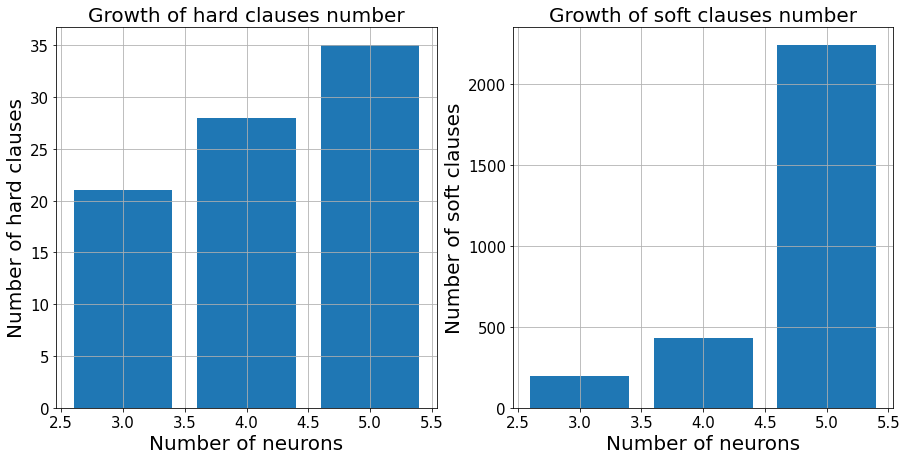

In [36]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7))

plot_bar(
    ax[0], 
    n_neurons, 
    n_hard_clauses, 
    xlab = 'Number of neurons', 
    ylab = 'Number of hard clauses',
    title = 'Growth of hard clauses number'
)

plot_bar(
    ax[1], 
    n_neurons, 
    n_soft_clauses, 
    xlab = 'Number of neurons', 
    ylab = 'Number of soft clauses',
    title = 'Growth of soft clauses number'
)

## CPU time VS number of neurons

Here, we fix all experimental parameters, to check how much CPU time is required
for WCNF Fu Malik computation, depending on the number of neurons.

We also fix the size of the dataset.

In [11]:
results = []
n_neurons = [2, 3, 4, 5]

def check_first_feature(x):
    return x[0] == True

target_func = check_first_feature
data_size = 30
train_percentage = 0.7
do_computations = True
prepare_balanced = False

for n in n_neurons:
    res = run_experiment(
        n_neurons = n,
        target_func = check_first_feature,
        data_size = data_size,
        train_percentage = train_percentage,
        do_computations = do_computations,
        prepare_balanced = prepare_balanced
    )
    results.append(
        res
    )

In [16]:
cpu_times = [r['cpu_time'] for r in results]

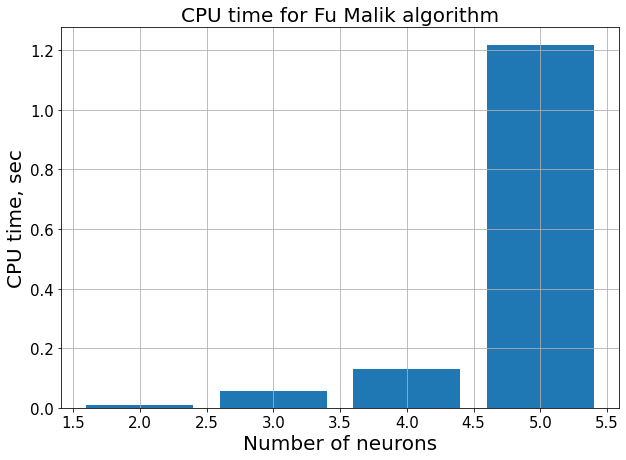

In [20]:
fig, ax = plt.subplots(figsize = (10, 7))


plot_bar(
    ax, 
    n_neurons, 
    cpu_times, 
    xlab = 'Number of neurons', 
    ylab = 'CPU time, sec',
    title = 'CPU time for Fu Malik algorithm'
)

In [10]:
cpu_times

[0.008298978000311763,
 0.07060971000009886,
 0.38130038700001023,
 2.5603753380000853]

In [22]:
train_accuracies = [r['train_acc'] for r in results]
test_accuracies = [r['test_acc'] for r in results]
print(train_accuracies)
print(test_accuracies)

[0.7619047619047619, 0.7619047619047619, 0.5714285714285714, 0.7142857142857143]
[0.7777777777777778, 0.7777777777777778, 0.2222222222222222, 0.6666666666666666]


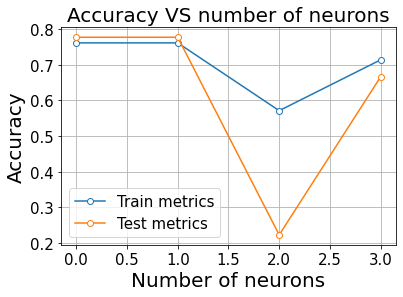

In [33]:
fig, ax = plt.subplots()

curve_dict = dict(
    marker = 'o',
    markerfacecolor = 'white'
)

font_size = 20

ax.plot(train_accuracies, **curve_dict)
ax.plot(test_accuracies, **curve_dict)
ax.set_xlabel('Number of neurons', fontsize = font_size)
ax.set_ylabel('Accuracy', fontsize = font_size)
ax.set_title('Accuracy VS number of neurons', fontsize = font_size)
ax.tick_params(axis='both', which='major', labelsize = labelsize)
ax.legend(['Train metrics', 'Test metrics'], prop = {'size': 15})
ax.grid()

In [34]:
Y_trains = [r['Y_train'] for r in results]
Y_tests = [r['Y_test'] for r in results]

In [37]:
def calc_percentage(arr):
    a = np.array(arr)
    n_of_trues = len(a[a == True])
    return n_of_trues / len(a)

true_percentages_train = [calc_percentage(Y_tr) for Y_tr in Y_trains]
true_percentages_test = [calc_percentage(Y_t) for Y_t in Y_tests]

In [39]:
true_percentages_train, true_percentages_test

([0.6190476190476191,
  0.5714285714285714,
  0.5714285714285714,
  0.5714285714285714],
 [0.5555555555555556,
  0.6666666666666666,
  0.1111111111111111,
  0.3333333333333333])

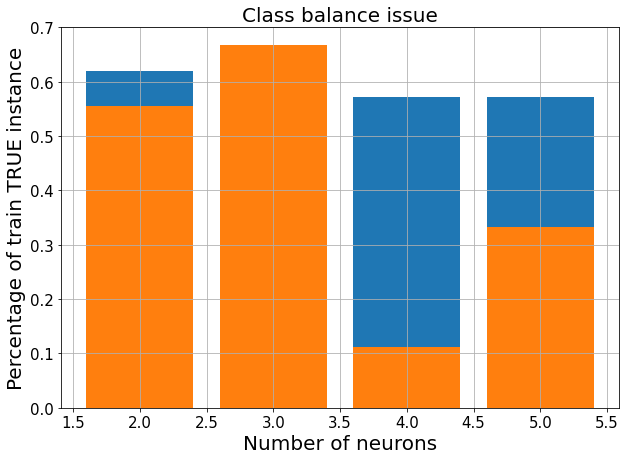

In [44]:
fig, ax = plt.subplots(figsize = (10, 7))

plot_bar(
    ax, 
    n_neurons, 
    true_percentages_train, 
    xlab = 'Number of neurons', 
    ylab = 'Percentage of train TRUE instance',
    title = 'Class balance issue'
)

plot_bar(
    ax, 
    n_neurons, 
    true_percentages_test, 
    xlab = 'Number of neurons', 
    ylab = 'Percentage of train TRUE instance',
    title = 'Class balance issue'
)
ax.grid()

## Comparison with 1-layer FFNN